In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score
from umap import UMAP

In [2]:
from cassava.transforms import get_test_transforms
from cassava.utils import make_confusion_matrix, plot_image, Unnormalize

In [5]:
from cassava.pipelines.train_model.nodes import score_model

In [3]:
%matplotlib inline

In [23]:
model = context.catalog.load('pretrained_model')

2020-12-10 20:35:12,907 - kedro.io.data_catalog - INFO - Loading data from `pretrained_model` (TorchLocalModel)...


In [6]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-10 20:33:48,025 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [10]:
train_labels = context.catalog.load('train_labels')

2020-12-10 20:34:31,794 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [11]:
parameters = context.catalog.load('parameters')

2020-12-10 20:34:32,119 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [12]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-10 20:34:32,540 - kedro.pipeline.node - INFO - Running node: split: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [14]:
scores, _ = score_model(model, train_images_torch, val_indices, parameters)
scores

2020-12-10 20:34:38,435 - root - INFO - Scoring model



2020-12-10 20:34:54,539 - root - INFO - Validation scores:
{'accuracy': 0.1280373831775701, 'f1_score': 0.1638542986721818}


{'accuracy': 0.1280373831775701, 'f1_score': 0.1638542986721818}

In [15]:
# metrics = context.catalog.load('train_metrics')

In [16]:
# metrics['last_epoch']

In [17]:
# plt.figure()
# sns.lineplot(data=metrics['train_losses'], label='train_loss')
# plt.show()

# plt.figure()
# sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
# plt.show()

In [18]:
# train_indices, val_indices = context.catalog.load('train_indices'), context.catalog.load('val_indices')

In [19]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-10 20:35:02,169 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


{'accuracy': 0.8616822429906542,
 'confusion_matrix': array([[  89,   16,    4,    7,   40],
        [  20,  243,    4,   13,   24],
        [   1,    8,  247,   10,   16],
        [   9,   30,   70, 1922,   42],
        [  44,   31,   33,   22,  265]]),
 'f1_score': 0.8645532619785615}

In [20]:
#!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb454666430>
Traceback (most recent call last):
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


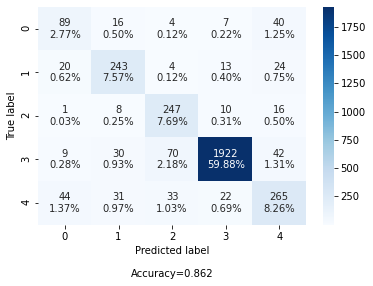

In [21]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [22]:
model = context.catalog.load('model')

2020-12-10 20:35:09,281 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


In [25]:
model = model.eval()

In [26]:
train_images_torch.transform = get_test_transforms()

In [27]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [28]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


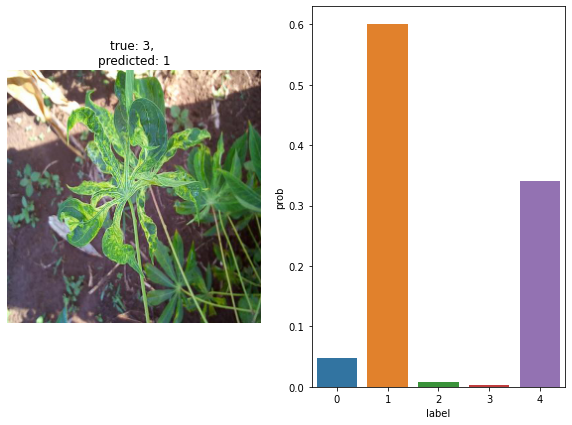

In [37]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [38]:
from sklearn.calibration import calibration_curve

In [39]:
from cassava.utils import DatasetFromSubset

In [44]:
indices = np.random.choice(range(len(train_images_torch)), 1000)

In [45]:
train_images_torch.transform = None

In [46]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=indices),
                      transform=get_test_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [47]:
predictions = {}
true_labels = []

invtemps = [0.75, 1, 1.25]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


In [48]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

In [49]:
true_labels[:10]

array([1, 3, 0, 3, 0, 0, 3, 3, 4, 3])

In [50]:
predictions[1][:10]

array([[1.70125306e-01, 1.13191139e-02, 5.16968109e-02, 2.44952343e-08,
        7.66858757e-01],
       [1.20726684e-02, 9.86450553e-01, 6.32488300e-05, 8.82553431e-05,
        1.32516399e-03],
       [7.09303319e-02, 9.29062963e-01, 2.69566303e-09, 1.75103363e-08,
        6.64674189e-06],
       [3.68256908e-04, 9.55927499e-06, 9.88404274e-01, 8.16663430e-07,
        1.12169543e-02],
       [7.90701506e-06, 1.98031608e-02, 9.06841815e-01, 1.39291927e-07,
        7.33469799e-02],
       [9.41293180e-01, 5.86938895e-02, 1.12067471e-06, 2.86130785e-07,
        1.14830445e-05],
       [1.45433486e-01, 8.24650586e-01, 2.20819507e-02, 2.34506902e-12,
        7.83391390e-03],
       [5.93078556e-03, 9.29141045e-01, 4.83448326e-04, 7.15947535e-05,
        6.43730834e-02],
       [8.94772351e-01, 7.19335876e-05, 3.14286954e-05, 1.06151312e-11,
        1.05124280e-01],
       [6.47314591e-04, 9.63095248e-01, 1.36166398e-06, 1.05254818e-03,
        3.52035016e-02]])

<ipython-input-51-a02fec00b023>:10: UserWarning: Attempting to set identical bottom == top == 0.12 results in singular transformations; automatically expanding.
  plt.ylim(min(accuracies), max(accuracies))


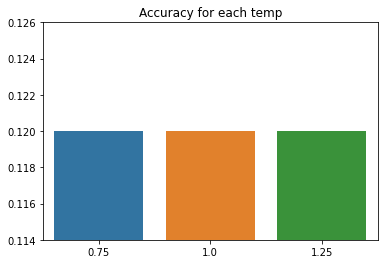

In [51]:
accuracies = []
for temp in invtemps:
    pred_probs = predictions[temp]
    pred_labels = np.argmax(pred_probs, 1)
    
    accuracies.append(accuracy_score(true_labels, pred_labels))
plt.figure()
sns.barplot(x=invtemps, y=accuracies)
plt.title('Accuracy for each temp')
plt.ylim(min(accuracies), max(accuracies))
plt.show()

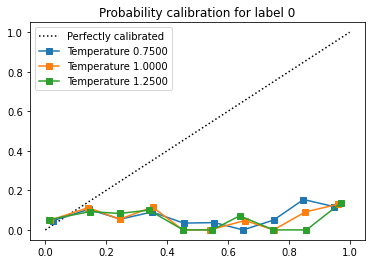

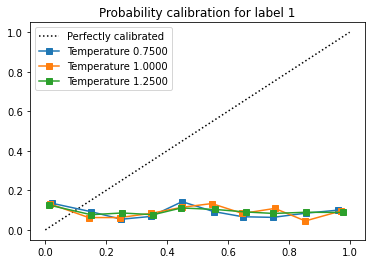

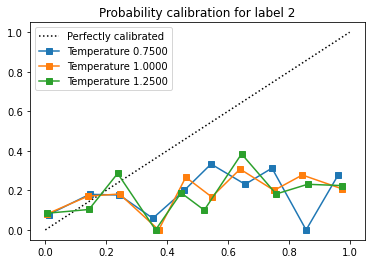

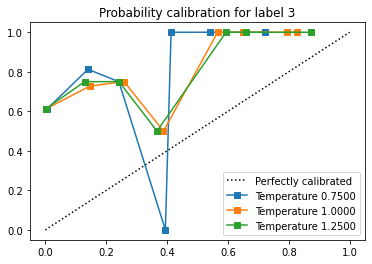

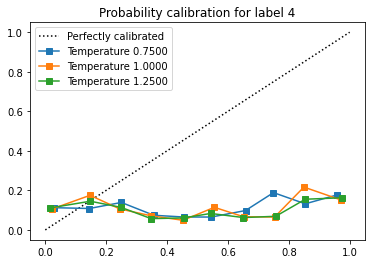

In [52]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()